# Review Opinion Ectraction
### 1. Preprocessing
- data scrapy
- data cleaning(another file)

### 2. Extract opinion 
- POS ONLY
- POS and dependency analysis
- candidate generate(filter low frequencies?)
- Rough(Recall-Oriented Understudy for Gisting Evaluation) to evaluate

### 3. Semantic similarity calculation and clustering

In [1]:
from sklearn import cluster
from sklearn import metrics
import sklearn
import os
import glob
import re
import itertools
from collections import Counter
from matplotlib import pyplot as plt

from nltk.tokenize import word_tokenize
import gensim
from gensim.models import KeyedVectors 
from gensim.scripts.glove2word2vec import glove2word2vec

import sys
import gc
import pandas as pd
import spacy
import time
import textacy
import re
import nltk
from collections import defaultdict
from itertools import takewhile
from operator import itemgetter
import re

from cytoolz import itertoolz
from numpy import nanmin, nanmax, zeros, NaN
import numpy as np
from spacy.parts_of_speech import CONJ, DET, NOUN, VERB
from spacy.tokens.span import Span as SpacySpan
from spacy.lang.en.stop_words import STOP_WORDS

import textacy
from textacy import spacy_utils, text_utils
from textacy.compat import unicode_
from textacy.spacy_utils import (normalized_str, get_main_verbs_of_sent,
                                 get_subjects_of_verb, get_objects_of_verb,
                                 get_span_for_compound_noun,
                                 get_span_for_verb_auxiliaries)
from textacy.constants import NUMERIC_NE_TYPES, REPORTING_VERBS
from wordcloud import WordCloud, ImageColorGenerator
from wordcloud import WordCloud

pd.set_option('max_colwidth',-1)
pd.set_option('max_row',100)

a = time.time()

/home/wang/anaconda/lib/python3.6/site-packages/textacy/spacy_utils.py:25: DeprecationWarning: The `spacy_utils` module is deprecated and will be removed in v0.7.0.Use the `textacy.spacier` subpackage instead.
  action="once")


# 2. Data Preprocessing and opinion extraction

In [2]:
#=================================   Data Preprocessing   ===================================

# 0. the very initial preprocessing work is in another file

#1. import the preprocessed data
text = pd.read_csv('./phrases.csv')

#2. phrase the data we have
def collect_phrases(string):
    return re.findall("\'(.*?)\'", string[1:-1])
phrases = list(itertools.chain(*text['candidates2'].map(collect_phrases)))
phrases = pd.DataFrame(phrases, columns=['phrases'])
phrases['phrases'] = phrases['phrases'].apply(lambda x:x.strip())

#3. clean data
#3.1 drop the very short phrases
phrases['length'] = phrases['phrases'].apply(len)
phrases = phrases.sort_values(by = 'length', ascending=False)
phrases = phrases[phrases['length'] > 6]   #可以调整
phrases = phrases.reset_index(drop=True)

#3.2 drop the add new feature -- count of phrases
cnt = Counter(phrases['phrases'].tolist())
phrases['count'] = phrases['phrases'].apply(lambda x:cnt[x])
phrases = phrases[phrases['count'] > 9]

# 3.3 others
phrases = phrases.drop_duplicates(keep='first', inplace=False)
phrases = phrases.sort_values(by = 'count', ascending=False)
phrases = phrases.reset_index(drop=True)

del text, phrases['length'], cnt
gc.collect()

49

# 3. Semantic similarity calculation and clustering
- The final method id word mebedding + Word Mover's Distance(https://vene.ro/blog/word-movers-distance-in-python.html)  
- We used Glove and Word2vec embedding models

- https://en.wikipedia.org/wiki/Word_embedding
- https://en.wikipedia.org/wiki/Word2vec
- https://nlp.stanford.edu/projects/glove/

```
##citation: 
# * `Ofir Pele and Michael Werman "A linear time histogram metric for improved SIFT matching"
#   <http://www.cs.huji.ac.il/~werman/Papers/ECCV2008.pdf>`_
# * `Ofir Pele and Michael Werman "Fast and robust earth mover's distances"
#   <https://ieeexplore.ieee.org/document/5459199/>`_
# * `Matt Kusner et al. "From Word Embeddings To Document Distances"
#   <http://proceedings.mlr.press/v37/kusnerb15.pdf>`_.
```

In [3]:
#=================================   Compare Similarity of phrases   ===================================

# 1. Load pretrained model：glove&word2vec
model_w2v = KeyedVectors.load_word2vec_format(
    './pretrained_model/GoogleNews-vectors-negative300.bin', binary=True)

# glove_input_file = './pretrained_model/glove.840B.300d.txt'
# word2vec_output_file = './pretrained_model/glove.840B.300d.txt.word2vec'
# glove2word2vec(glove_input_file, word2vec_output_file)
model_glove = KeyedVectors.load_word2vec_format(
    './pretrained_model/glove.840B.300d.txt.word2vec', binary=False)

In [4]:
# 2. make the semantic distance matric
similarity_matrix_glove = np.zeros((phrases.shape[0], phrases.shape[0]))
similarity_matrix_w2v = np.zeros((phrases.shape[0], phrases.shape[0]))
for i, x in enumerate(phrases['phrases']):
    if i%50 == 0:
        print("processing...%.1f%%..."%(100*i/phrases.shape[0]))
    for j, y in enumerate(phrases['phrases']):
        similarity_matrix_glove[i][j] = model_glove.wmdistance(x, y)
        similarity_matrix_w2v[i][j] = model_w2v.wmdistance(x, y)

processing...0.0%...
processing...9.3%...
processing...18.6%...
processing...27.9%...
processing...37.2%...
processing...46.5%...
processing...55.8%...
processing...65.1%...
processing...74.3%...
processing...83.6%...
processing...92.9%...


# 4. Make clustering

In [5]:
##======================  clustering based on semantic distance  =======================##

#we tried two clustering mathod there
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster
sc = cluster.SpectralClustering(n_clusters=500, 
                        affinity='precomputed', 
                        assign_labels= 'discretize')
# aff = cluster.AffinityPropagation(n_clusters=500, 
#                         affinity='precomputed',)
km = cluster.KMeans(n_clusters=500, precompute_distances=True)

#evaluate clustering with davies bouldin index
labels_glove_km = km.fit(similarity_matrix_glove).labels_
labels_w2v_km = km.fit(similarity_matrix_w2v).labels_

labels_glove_sc = sc.fit(similarity_matrix_glove).labels_
labels_w2v_sc = sc.fit(similarity_matrix_w2v).labels_

In [6]:
print("silhouette_score of word2vec_kmeans, word2vec_Spectral, glove_kmeans, glove_Spectral " )
res = []
for dis_matrix, labels in itertools.product(
    [similarity_matrix_w2v, similarity_matrix_glove], [labels_w2v_km, labels_w2v_sc]):
    temp = metrics.silhouette_score(dis_matrix, labels, metric='precomputed')
    res.append(temp)
    print("%.3f"%temp)  

silhouette_score of word2vec_kmeans, word2vec_Spectral, glove_kmeans, glove_Spectral 
0.129
-0.130
0.071
-0.127


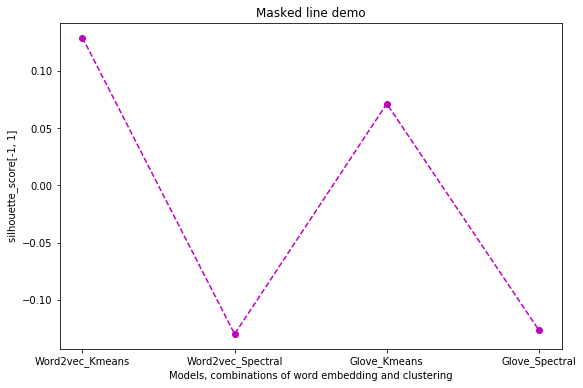

In [56]:
import matplotlib.pyplot as plt
import numpy as np

y = res
x = ['Word2vec_Kmeans', 'Word2vec_Spectral', 'Glove_Kmeans', 'Glove_Spectral']

plt.figure(figsize=(9,6))
plt.plot(x, y, linestyle='--', marker='o', color='m')
plt.xlabel('Models, combinations of word embedding and clustering')
plt.ylabel('silhouette_score[-1, 1]')
plt.title('Masked line demo')
plt.savefig("models.png")
plt.show()



# 5. visualization

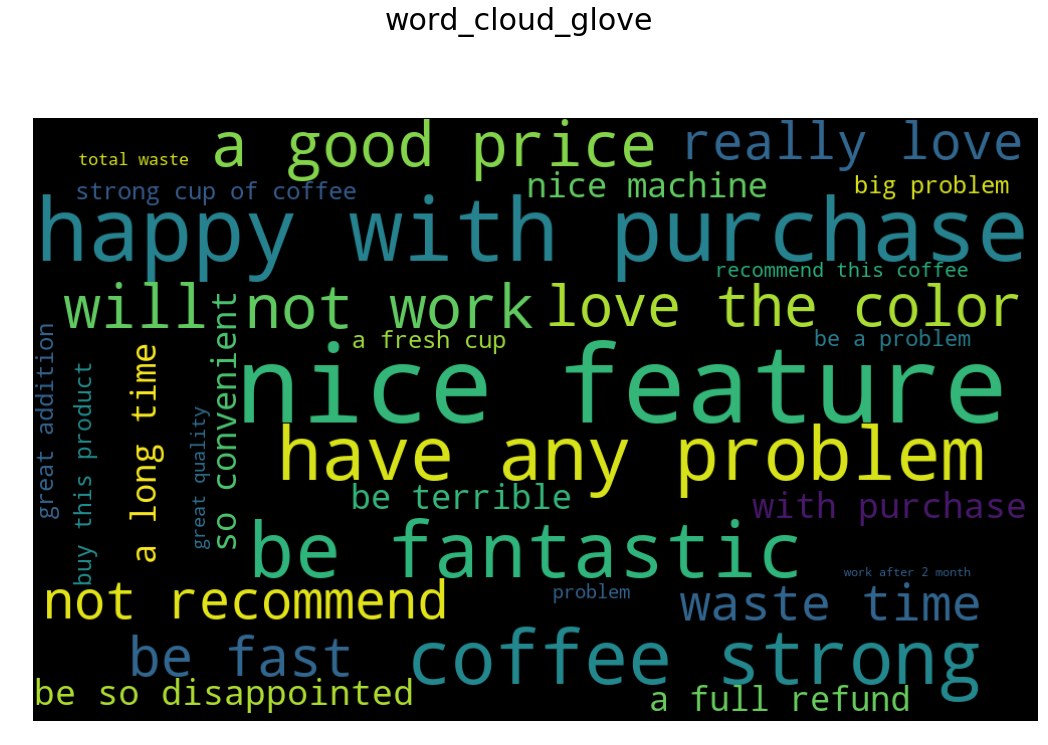

In [54]:
##======================  visualization of the clustering result  =======================##

def generate_wc(fname, df):
    #prepare for visualization
    frequency = df.set_index('phrases', drop = True).to_dict()['total_count']
    
    # Generate a word cloud image
    picture  =WordCloud(width=1000, height=600, margin=2)
    wordcloud = picture.generate_from_frequencies(frequency)
    plt.figure(figsize=(18, 12))
    plt.imshow(wordcloud, interpolation="kaiser")
    plt.axis("off")
#     plt.savefig("wordcloud.png")
    plt.suptitle(fname, fontsize=30)
    plt.show()
    
# for n in [30, 50, 100, 300, 500]:
km = cluster.KMeans(n_clusters=500, precompute_distances=True)
clusters_w2v_km = km.fit_predict(similarity_matrix_w2v)
clusters = pd.DataFrame(clusters_w2v_km, columns=['clusters'])
phrases_new = pd.concat([phrases, clusters], axis=1)
temp = phrases_new.groupby('clusters')['count'].sum()
temp = temp.to_frame(name='total_count')
temp = temp.reset_index(drop = False)
temp_1 = phrases_new.drop_duplicates(subset='clusters', keep='first', inplace=False)
temp_1 = pp.reset_index(drop=True)
temp_1 = temp_1.merge(temp)
generate_wc('word_cloud_glove', pp[['phrases', 'total_count']])